In [ ]:
from google.colab import files
uploaded = files.upload()


Saving heart.csv to heart.csv
Saving diabetes.csv to diabetes.csv
Saving stroke.csv to stroke.csv
Saving kidney.csv to kidney.csv


### Generating Heatmaps for Feature Correlation

To understand the relationships between features in each dataset, we will generate heatmaps of their correlation matrices. Before generating the heatmaps, the data will be preprocessed using the same steps applied in the previous sections:

1.  **Handle Missing Values in Target Column**: Rows with `NaN` values in the target column will be dropped.
2.  **Convert Target Column to Numerical**: If the target column is categorical (object type), it will be converted to numerical using `pd.factorize`.
3.  **One-Hot Encode Categorical Features**: All remaining categorical columns (object type) will be one-hot encoded.
4.  **Fill Missing Numerical Values**: Any remaining `NaN` values in numerical columns will be filled with the column's mean.

After preprocessing, the Pearson correlation matrix will be computed for each dataset, and then visualized using `seaborn.heatmap`.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for name, df in datasets.items():
    print("\n" + "="*60)
    print(f"Generating Heatmap for {name}")
    print("="*60)

    target_col = target_columns_map.get(name)

    if target_col is None:
        print(f"Error: No target column defined for {name}. Skipping heatmap generation.")
        continue

    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in {name}. Skipping heatmap generation.")
        continue

    # Make a copy to avoid modifying the original dataframe in the loop
    df_processed = df.copy()

    # Drop rows where the target column has NaN values
    df_processed = df_processed.dropna(subset=[target_col])

    if len(df_processed) == 0:
        print(f"Warning: {name} became empty after dropping NaN values in target column. Skipping heatmap generation.")
        continue

    # Convert the target column to numerical if it's categorical
    if df_processed[target_col].dtype == 'object':
        df_processed[target_col] = pd.factorize(df_processed[target_col])[0]

    # Identify categorical columns for one-hot encoding
    categorical_cols = df_processed.select_dtypes(include='object').columns.tolist()

    # Apply one-hot encoding to remaining categorical columns
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, dummy_na=False)

    # Fill remaining NaN values in numerical columns with the mean
    for col in df_processed.columns:
        if df_processed[col].dtype in ['int64', 'float64'] and df_processed[col].isnull().any():
            df_processed[col] = df_processed[col].fillna(df_processed[col].mean())

    try:
        # Calculate the correlation matrix
        correlation_matrix = df_processed.corr()

        # Plotting the heatmap
        plt.figure(figsize=(15, 12))
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'Correlation Matrix for {name}')
        plt.show()
    except Exception as e:
        print(f"Error generating heatmap for {name}: {e}")

NameError: name 'datasets' is not defined

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

!pip install xgboost
from xgboost import XGBClassifier


In [ ]:
# Replace filenames with your actual dataset names
dataset_files = [
    "heart.csv",
    "diabetes.csv",
    "stroke.csv",
    "kidney.csv"
]

datasets = {f"Dataset_{i+1}": pd.read_csv(file)
            for i, file in enumerate(dataset_files)}


In [ ]:
def train_and_evaluate(df, target_col="target"):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scaling (important for Logistic Regression)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "XGBoost": XGBClassifier(
            eval_metric="logloss",
            random_state=42,
            use_label_encoder=False
        )
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        results[name] = acc

        print(f"\n{name}")
        print("Accuracy:", acc)
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))

    return results


In [ ]:
all_results = {}

# Define target columns for each dataset
target_columns_map = {
    "Dataset_1": "target",  # For heart.csv
    "Dataset_2": "Outcome", # For diabetes.csv
    "Dataset_3": "stroke",  # For stroke.csv
    "Dataset_4": "classification" # For kidney.csv
}

for name, df in datasets.items():
    print("\n" + "="*50)
    print(f"Training models for {name}")
    print("="*50)

    target_col = target_columns_map.get(name)

    if target_col is None:
        print(f"Error: No target column defined for {name}. Skipping.")
        continue

    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in {name}. Skipping.")
        continue

    # Drop rows where the target column has NaN values
    df = df.dropna(subset=[target_col])

    if len(df) == 0:
        print(f"Warning: {name} became empty after dropping NaN values in target column. Skipping.")
        continue

    # Preprocessing: Handle categorical features and missing values

    # Convert the target column to numerical if it's categorical (e.g., 'ckd'/'notckd' to 0/1)
    if df[target_col].dtype == 'object':
        df[target_col] = pd.factorize(df[target_col])[0]

    # Identify categorical columns for one-hot encoding (excluding the target column, if it was already handled)
    categorical_cols = df.select_dtypes(include='object').columns.tolist()

    # Apply one-hot encoding to remaining categorical columns
    df = pd.get_dummies(df, columns=categorical_cols, dummy_na=False)

    # Fill remaining NaN values in numerical columns with the mean
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64'] and df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mean())

    try:
        results = train_and_evaluate(df, target_col=target_col)
        all_results[name] = results
    except Exception as e:
        print(f"Error training models for {name}: {e}")


Training models for Dataset_1

Logistic Regression
Accuracy: 0.875
Confusion Matrix:
 [[ 0  7]
 [ 0 49]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.88      1.00      0.93        49

    accuracy                           0.88        56
   macro avg       0.44      0.50      0.47        56
weighted avg       0.77      0.88      0.82        56



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest
Accuracy: 0.8214285714285714
Confusion Matrix:
 [[ 0  7]
 [ 3 46]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.87      0.94      0.90        49

    accuracy                           0.82        56
   macro avg       0.43      0.47      0.45        56
weighted avg       0.76      0.82      0.79        56


XGBoost
Accuracy: 0.8035714285714286
Confusion Matrix:
 [[ 0  7]
 [ 4 45]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.87      0.92      0.89        49

    accuracy                           0.80        56
   macro avg       0.43      0.46      0.45        56
weighted avg       0.76      0.80      0.78        56


Training models for Dataset_2

Logistic Regression
Accuracy: 0.7142857142857143
Confusion Matrix:
 [[82 18]
 [26 28]]
Classification Report

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:10:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest
Accuracy: 0.7467532467532467
Confusion Matrix:
 [[83 17]
 [22 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       100
           1       0.65      0.59      0.62        54

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154


XGBoost
Accuracy: 0.7337662337662337
Confusion Matrix:
 [[80 20]
 [21 33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.62      0.61      0.62        54

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154


Training models for Dataset_3

Logistic Regression
Accuracy: 0.9510763209393346
Confusion Matrix:
 [[971   1]
 [ 49   1]]
Classification Re

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:10:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest
Accuracy: 0.9510763209393346
Confusion Matrix:
 [[971   1]
 [ 49   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.50      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.73      0.51      0.51      1022
weighted avg       0.93      0.95      0.93      1022


XGBoost
Accuracy: 0.949119373776908
Confusion Matrix:
 [[965   7]
 [ 45   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       972
           1       0.42      0.10      0.16        50

    accuracy                           0.95      1022
   macro avg       0.69      0.55      0.57      1022
weighted avg       0.93      0.95      0.93      1022


Training models for Dataset_4

Logistic Regression
Accuracy: 0.9875


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:10:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels

Confusion Matrix:
 [[49  1  0]
 [ 0  0  0]
 [ 0  0 30]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00        30

    accuracy                           0.99        80
   macro avg       0.67      0.66      0.66        80
weighted avg       1.00      0.99      0.99        80


Random Forest
Accuracy: 1.0
Confusion Matrix:
 [[50  0]
 [ 0 30]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        30

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


XGBoost
Accuracy: 1.0
Confusion Matrix:
 [[50  0]
 [ 0 30]]
Classification Report:
               precision    recall  f

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:10:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
summary = pd.DataFrame(all_results).T
summary


,Logistic Regression,Random Forest,XGBoost
Dataset_1,0.875000,0.821429,0.803571
Dataset_2,0.714286,0.746753,0.733766
Dataset_3,0.951076,0.951076,0.949119
Dataset_4,0.987500,1.000000,1.000000


In [ ]:
from sklearn.metrics import accuracy_score

def train_test_accuracy_check(df, target_col="target"):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "XGBoost": XGBClassifier(
            eval_metric="logloss",
            random_state=42,
            use_label_encoder=False
        )
    }

    for name, model in models.items():
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)

        print(f"\n{name}")
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Testing Accuracy : {test_acc:.4f}")
        print(f"Difference       : {train_acc - test_acc:.4f}")


In [ ]:
for name, df in datasets.items():
    print("\n" + "="*60)
    print(f"Overfitting Check for {name}")
    print("="*60)

    # Re-use the target_columns_map defined earlier
    target_col = target_columns_map.get(name)

    if target_col is None:
        print(f"Error: No target column defined for {name}. Skipping.")
        continue

    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in {name}. Skipping.")
        continue

    # Drop rows where the target column has NaN values
    df_processed = df.dropna(subset=[target_col]).copy() # Make a copy to avoid SettingWithCopyWarning

    if len(df_processed) == 0:
        print(f"Warning: {name} became empty after dropping NaN values in target column. Skipping.")
        continue

    # Convert the target column to numerical if it's categorical
    if df_processed[target_col].dtype == 'object':
        df_processed[target_col] = pd.factorize(df_processed[target_col])[0]

    # Identify categorical columns for one-hot encoding
    categorical_cols = df_processed.select_dtypes(include='object').columns.tolist()

    # Apply one-hot encoding to remaining categorical columns
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, dummy_na=False)

    # Fill remaining NaN values in numerical columns with the mean
    for col in df_processed.columns:
        if df_processed[col].dtype in ['int64', 'float64'] and df_processed[col].isnull().any():
            df_processed[col] = df_processed[col].fillna(df_processed[col].mean())

    try:
        train_test_accuracy_check(df_processed, target_col=target_col)
    except Exception as e:
        print(f"Error during overfitting check for {name}: {e}")


Overfitting Check for Dataset_1

Logistic Regression
Training Accuracy: 0.8839
Testing Accuracy : 0.8750
Difference       : 0.0089

Random Forest
Training Accuracy: 0.9688
Testing Accuracy : 0.8214
Difference       : 0.1473

XGBoost
Training Accuracy: 0.9688
Testing Accuracy : 0.8036
Difference       : 0.1652

Overfitting Check for Dataset_2

Logistic Regression
Training Accuracy: 0.7915
Testing Accuracy : 0.7143
Difference       : 0.0772


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:17:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest
Training Accuracy: 1.0000
Testing Accuracy : 0.7468
Difference       : 0.2532

XGBoost
Training Accuracy: 1.0000
Testing Accuracy : 0.7338
Difference       : 0.2662

Overfitting Check for Dataset_3


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:17:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Logistic Regression
Training Accuracy: 0.9513
Testing Accuracy : 0.9511
Difference       : 0.0002

Random Forest
Training Accuracy: 1.0000
Testing Accuracy : 0.9511
Difference       : 0.0489

XGBoost
Training Accuracy: 0.9998
Testing Accuracy : 0.9491
Difference       : 0.0506

Overfitting Check for Dataset_4

Logistic Regression
Training Accuracy: 1.0000
Testing Accuracy : 0.9875
Difference       : 0.0125


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:17:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest
Training Accuracy: 1.0000
Testing Accuracy : 1.0000
Difference       : 0.0000

XGBoost
Training Accuracy: 1.0000
Testing Accuracy : 1.0000
Difference       : 0.0000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:17:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
#Although ensemble models achieved comparable accuracy, Logistic Regression demonstrated superior generalization with minimal overfitting. Given its interpretability and robustness, it was selected as the final model for deployment


Heatmap for diabetes_clean


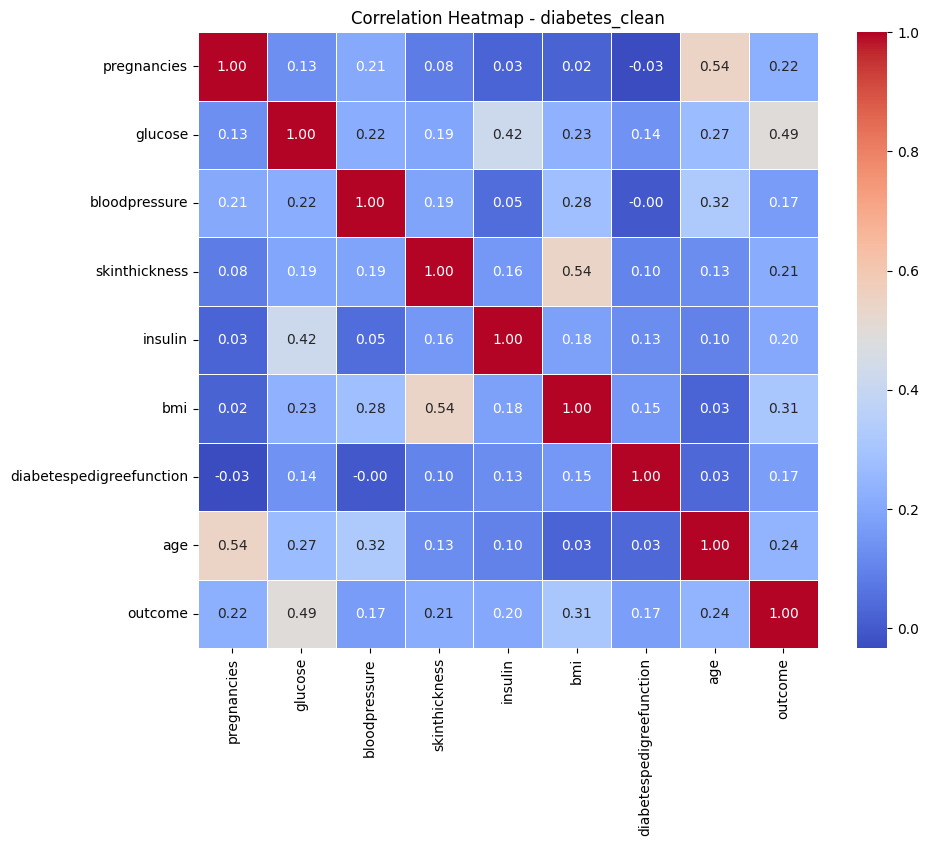


Correlation with outcome:
outcome                     1.000000
glucose                     0.492782
bmi                         0.312038
age                         0.238356
pregnancies                 0.221898
skinthickness               0.214873
insulin                     0.203790
diabetespedigreefunction    0.173844
bloodpressure               0.165723
Name: outcome, dtype: float64

Heatmap for heart_clean


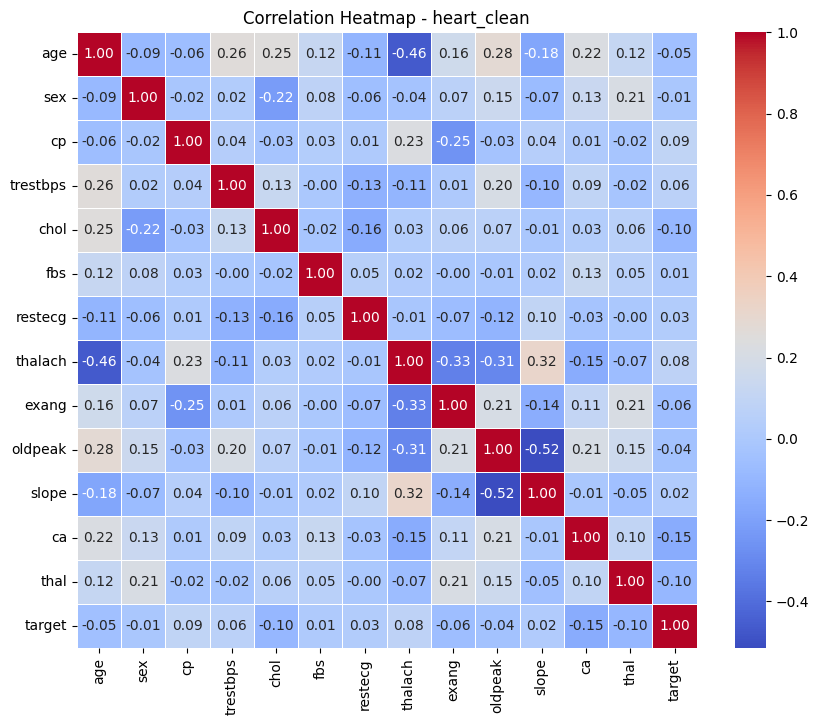


Correlation with target:
target      1.000000
cp          0.089952
thalach     0.081410
trestbps    0.064894
restecg     0.027670
slope       0.018116
fbs         0.014579
sex        -0.008764
oldpeak    -0.038478
age        -0.047963
exang      -0.059781
chol       -0.096198
thal       -0.100081
ca         -0.151616
Name: target, dtype: float64

Heatmap for kidney_clean


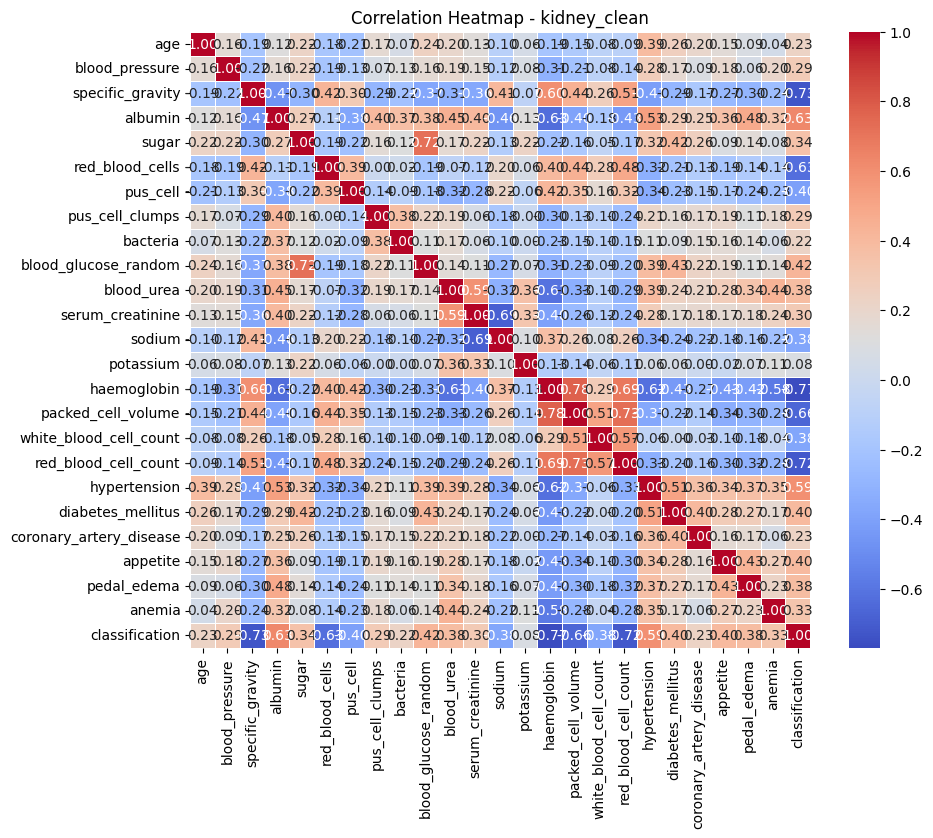


Correlation with classification:
classification             1.000000
albumin                    0.627090
hypertension               0.592895
blood_glucose_random       0.419672
appetite                   0.397072
diabetes_mellitus          0.395316
blood_urea                 0.380605
pedal_edema                0.379163
sugar                      0.344070
anemia                     0.330260
serum_creatinine           0.299969
blood_pressure             0.294077
pus_cell_clumps            0.289498
coronary_artery_disease    0.230968
age                        0.227268
bacteria                   0.221212
potassium                  0.084541
sodium                    -0.375674
white_blood_cell_count    -0.376930
pus_cell                  -0.403575
red_blood_cells           -0.629978
packed_cell_volume        -0.658870
red_blood_cell_count      -0.720243
specific_gravity          -0.732163
haemoglobin               -0.768919
Name: classification, dtype: float64

Heatmap for stroke_clean


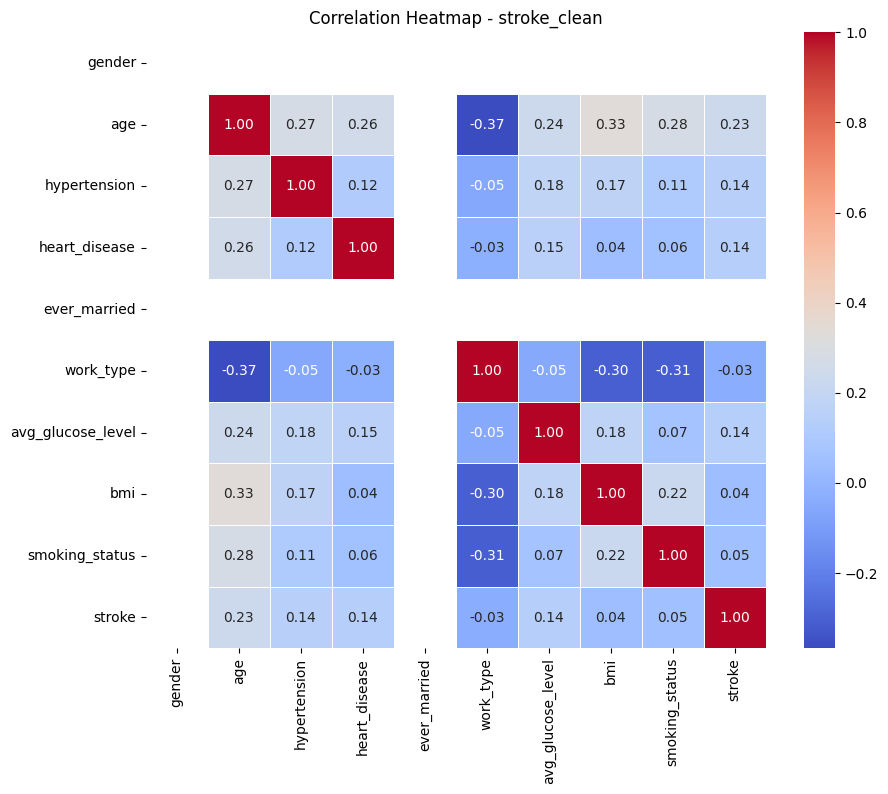


Correlation with stroke:
stroke               1.000000
age                  0.232331
hypertension         0.142515
avg_glucose_level    0.138936
heart_disease        0.137938
smoking_status       0.051558
bmi                  0.042374
work_type           -0.033756
gender                    NaN
ever_married              NaN
Name: stroke, dtype: float64


In [6]:
# ===== SINGLE CELL HEATMAP FOR 4 DATASETS (DIFFERENT TARGETS) =====

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Define datasets with their target column names
datasets = {
    "diabetes_clean": "outcome",   # change if needed
    "heart_clean": "target",
    "kidney_clean": "classification",
    "stroke_clean": "stroke"
}

for file, target_col in datasets.items():
    print("\n" + "="*60)
    print(f"Heatmap for {file}")
    print("="*60)

    # Fix: Append '.csv' to the filename
    df = pd.read_csv(f"{file}.csv")

    # Correlation matrix
    corr_matrix = df.corr(numeric_only=True)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.5
    )
    plt.title(f"Correlation Heatmap - {file}")
    plt.show()

    # Show correlation with that dataset's target
    if target_col in corr_matrix.columns:
        print(f"\nCorrelation with {target_col}:")
        print(corr_matrix[target_col].sort_values(ascending=False))
    else:
        print(f"\nTarget column '{target_col}' not found.")